In [645]:
import numpy as np
from numpy import random
import h5py
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mpcol
import dill
import os
import pdb
import pyute as ut
import size_contrast_figures as scf
# from matplotlib.colors import CenteredNorm

# file_exp  = '7197_160_001.exp'
file_data = 'AllData_NatureSubmission.mat'

%matplotlib notebook

In [646]:
def CenteredNorm(vcenter=0,halfrange=1,clip=False):
    return mpcol.Normalize(vmin=vcenter-halfrange,vmax=vcenter+halfrange,clip=clip)

# Load data

In [647]:
# # load experiment information

# def load_experiment(filename):
#     '''
#     Load experiment information. 
    
#     Parameters
#     ----------
#     filename : str
#         .exp file to load from.
#     '''
#     with h5py.File(filename, "r") as h5f:
#         stim_id = h5f["/TrialInfo/StimID"][:].astype("int")
#         stim_dict = h5f["/Experiment/stim/stim"][:].transpose().astype("bool")
#         trial_index = h5f["TrialIndex"][:].astype("int") - 1  # convert to 0-based indexing
#     return stim_dict, np.squeeze(stim_id), np.squeeze(trial_index)

# stim_dict, stim_id, trial_index = load_experiment(file_exp)

In [648]:
# load ROI information

def load_2D_dataset(f, name):
    shape = f[name].shape
    array = np.empty(shape)
    for w in range(shape[1]):
        for h in range(shape[0]):
            array[h,w] = f[name][h,w]
    return array

with h5py.File(file_data, 'r') as h5f:
    print(h5f.keys())
    sig_driven = load_2D_dataset(h5f, 'sigDriven') # significantly driven index (per neuron)
    group_index = load_2D_dataset(h5f, 'GroupIndex') # layer index (per neuron)
    stim_log = load_2D_dataset(h5f,'StimLog') # stim index [stimulus x piston]
print(sig_driven.shape, group_index.shape, stim_log.shape)

<KeysViewHDF5 ['#refs#', '#subsystem#', 'Actual', 'AlignFiles', 'BW', 'BestMW', 'BestStim', 'CI', 'CIdif', 'Centroids', 'Centroids_orig', 'ControlID', 'Curve95CI', 'Curves', 'Curves_test', 'Curves_train', 'DataIndex', 'DataSetDepth', 'DataSetIndex', 'DepthIndex', 'Experiment', 'FileIndex', 'Filenames', 'Files', 'Fns', 'GColors', 'Group', 'GroupIndex', 'GroupNames', 'ID', 'Index', 'Indiv', 'LD', 'Labels', 'LinIndex', 'M', 'MWSparsity', 'MainDir', 'Maps', 'Max', 'Max1W', 'MaxMW', 'Min', 'MouseIndex', 'MultiWhiskerUnit', 'NPW', 'NeuronType', 'NeuropilWeight', 'NotDriven', 'PTuned1W', 'PValues', 'PW', 'PW_GLM', 'RF', 'ROIindex', 'Raw', 'Responded', 'Response', 'SelectivityIndex', 'SingleWhiskerUnit', 'StimID', 'StimLog', 'StimLogs', 'StimMean', 'StimSparsity', 'Sum', 'SummationUnit', 'Thresh', 'TickLabels', 'TrialIndex', 'TunePValues', 'Vertices', 'WT', 'WhiskDirs', 'WhiskerIndex', 'WhiskerSparsity', 'XAxisLabels', 'f', 'largeEnough', 'load_L23', 'load_L23wiggle', 'load_L4', 'load_L5', 'lo

In [649]:
itr = 0
expt_ids = np.zeros((0,),dtype='int')
with h5py.File(file_data, 'r') as h5f:
#     for el in (h5f['Experiment']):
#         print(el)
    for iel,nroi in enumerate(h5f['numROIsPerFile']):
#         print(nroi)
        idx = list(h5f['DataSetIndex'])
#         print(idx)
        expt_ids = np.concatenate((expt_ids,idx[0][iel]*np.ones((int(nroi),))),axis=0)
#         print(el)
# #     for el in (h5f['MouseIndex']):
# #         print(el)
# #         itr +=1
#     for el in (h5f['DataSetIndex']):
#         print(el)
#         itr += 1
#     for part in h5f:
#         print(part)
        
is_layer23 = np.zeros(idx[0].shape,dtype='bool')
for iexpt in range(is_layer23.shape[0]):
    is_layer23[iexpt] = len(np.where(idx[0] == iexpt)[0])>1        

expt_ids = expt_ids.astype('int')
print(len(el))


31


In [650]:
# load response per trial values (takes a few minutes)

with h5py.File(file_data, 'r') as h5f:
    raw = []
    for stim in h5f['Raw']: # 32
        temp = []
        for cell in stim: # 7793
            temp.append(h5f[cell][0])
        raw.append(temp)

print(len(raw), len(raw[0]), len(raw[0][0]), raw[0][0])

32 7793 20 [-0.1337925   0.75329287 -0.44491716  1.00340605  0.45112597 -0.55262304
  0.37980716  0.49321893 -0.23420083 -0.43197111  0.2850758  -0.45740138
 -0.64115831  0.61013487  0.70781514  0.6632043   0.46738403 -0.36325476
  0.35290464  0.10152502]


In [651]:
# determine indices of neurons to analyze

G = np.array([[1,2]]) # groups L4 & L2/3
index = np.equal(group_index.transpose(), G) # in group
# print(index.shape)
index = np.logical_and(sig_driven.transpose(), index) # significantly driven
# print(index.shape)
index = np.any(index, 1) # in any of the selected groups
print(index.shape, sum(index))

(7793,) 2692


# Compute tuning curves

In [709]:
# compute tuning curves
rng = random.default_rng(seed=42)

def split_n_times(data, n=3, equal=True, rng=rng):
    rng.shuffle(data)
    if equal:
        last = len(data) - (len(data) % n)
    else:
        last = len(data)
    out = []
    for i in range(n):
        out.append(data[i:last:n])
    return out

def create_curves(raw, n_splits=3, rng=random.default_rng(seed=42)):
    num_stim, num_cells = len(raw), len(raw[0])
    curves = np.empty([num_cells, num_stim, n_splits])
    for c in range(num_cells):
        for s in range(num_stim):
            if n_splits > 1:
                samples = split_n_times(raw[s][c], n_splits, rng=rng)
                vals = [np.mean(sample) for sample in samples]
            else: 
                vals = np.mean(raw[s][c])
            curves[c,s,:] = vals
    return curves

thirds = True
if thirds:
    n_splits = 3
else:
    n_splits = 2

curves = create_curves(raw, n_splits=n_splits) # compute tuning curves
n_trials_per_split = len(raw[0][0]) // n_splits
print(curves.shape)

(7793, 32, 3)


<IPython.core.display.Javascript object>


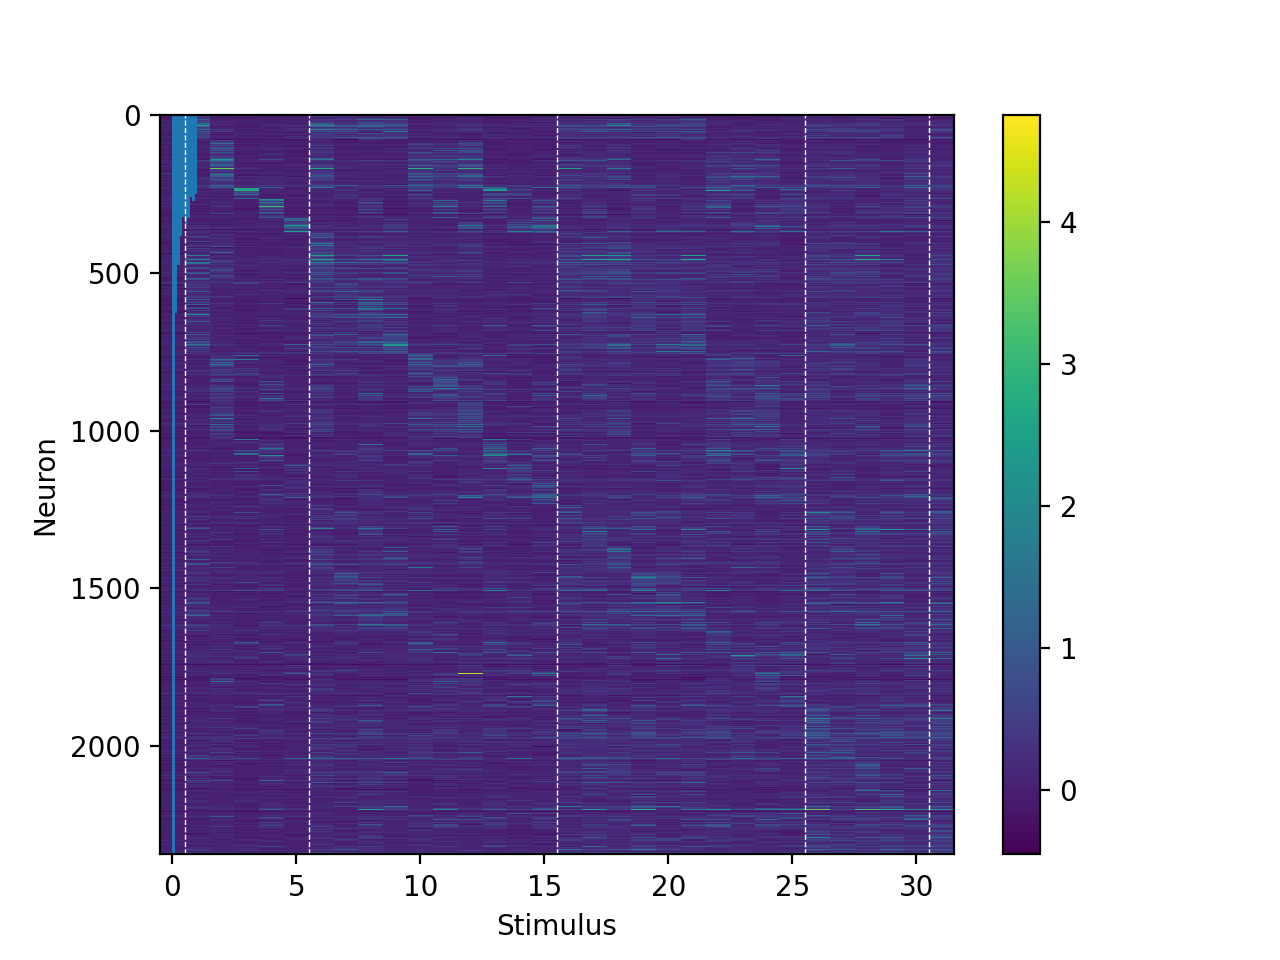

# sig: 4043


(array([4530.,  627.,  476.,  384.,  324.,  345.,  326.,  259.,  271.,
         251.]),
 array([8.30282040e-24, 9.99575899e-02, 1.99915180e-01, 2.99872770e-01,
        3.99830360e-01, 4.99787950e-01, 5.99745540e-01, 6.99703130e-01,
        7.99660720e-01, 8.99618310e-01, 9.99575899e-01]),
 <BarContainer object of 10 artists>)

In [710]:
# calculate correlation between first two thirds of the data

def curve_correlation(curves):
    p = np.empty((curves.shape[0],2))
    for idx, cell in enumerate(curves):
        p[idx, :] = stats.pearsonr(cell[:,0], cell[:,1])
    return p

plt.figure()
p = curve_correlation(curves[:,:,:2]) # compute correlation
print('# sig:', np.sum(p[:,1]<.05))
plt.hist(p[:,1])

In [711]:
# select only L2/3 & L4 neurons that are significantly driven and significantly correlated

# index1 = np.logical_and(index, p[:,1]<.05) # append signficantly correlated criterion

curves_sel = curves[index] # keep only correlated neurons
print(curves_sel.shape)

(2692, 32, 3)


In [712]:
def is_correlated(curves, pval_cutoff=0.05):
    p = curve_correlation(curves[:,:,:2]) # compute correlation
    index1 = (p[:,1] < pval_cutoff) # append signficantly correlated criterion
    return index1


In [713]:
# display curves calculated on last third of the data and ordered by first two thirds of the data

def sort_tuning_curves(these_curves):
    best_stim = np.argmax(these_curves, axis=1)
    # best_resp = np.amax(curves, axis=1)
    sel = selectivity(these_curves)
    sort_index = np.lexsort((1-sel, best_stim))
    return sort_index

def sort_stims_per_neuron(these_curves):
    best_stim = np.argmax(these_curves, axis=1)
    # best_resp = np.amax(curves, axis=1)
    sel = selectivity(these_curves)
    sort_index = np.lexsort((1-sel, best_stim))
    stim_sort_index = np.argsort(-these_curves[sort_index], axis=1)
    return stim_sort_index

def selectivity(these_curves):
    '''
    Compute vector selectivity. 
    '''
    sel = lambda x: 1 - (np.sqrt(sum(abs(x)**2))/max(x)-1)/(np.sqrt(len(x))-1)
    if np.ndim(these_curves)==1:
        return sel(these_curves)
    else:
        return np.apply_along_axis(sel, axis=1, arr=these_curves)
    
def tuning_curve_matrix(curves, sort=None, vertbars=True, LD=False, clim=None, norm_rows=False):
    if sort is True: curves = curves[sort_tuning_curves(curves),:]
    elif sort:       curves = curves[sort,:]
    if not LD: 
        cmap = plt.get_cmap('viridis')
        norm = None
        line_color = 'w'
        xlim = [-.5,31.5]
    else:
        cmap = plt.get_cmap('bwr')
        if clim==None: 
            clim = [np.min(curves[:]), np.max(curves[:])]
        norm = CenteredNorm(halfrange=np.max(np.abs(clim)))
        line_color = 'k'
        xlim = [5.5,31.5] # show multi-whisker stimuli only
    if not norm_rows:
        im = plt.imshow(curves, cmap=cmap, norm=norm, interpolation="none", aspect="auto") #, extent=[-.5, np.size(curves,1)-.5, np.size(curves,0)-.5, -.5]
    else:
        im = plt.imshow(curves/curves.max(1)[:,np.newaxis], cmap=cmap, norm=norm, interpolation="none", aspect="auto") #, extent=[-.5, np.size(curves,1)-.5, np.size(curves,0)-.5, -.5]
    if clim is not None: plt.clim(clim[0], clim[1])
    plt.xlim(xlim)
#     plt.plot([-.5,np.size(curves,1)+.5], [-.5,np.size(curves,0)+.5], '--', linewidth=1, color=line_color)
    if vertbars:
        if vertbars==True:
            vertbars=np.array([.5,5.5,15.5,25.5,30.5])
            if np.size(curves,1)==31: # no catch
                vertbars = vertbars[1:]-1
            elif np.size(curves,1)==26: # multi-piston stimuli only
                vertbars = vertbars[2:]-6
        for v in vertbars:
            plt.axvline(v, color=line_color, linestyle='--', linewidth=.5)
    plt.xlabel("Stimulus")
    plt.ylabel("Neuron")
    plt.colorbar()
    
is_c = is_correlated(curves_sel, pval_cutoff=0.05)
order = sort_tuning_curves(curves_sel[is_c][:,:,:2].mean(axis=2)) # determine order based on first two-thirds of data
tuning_curve_matrix(curves_sel[is_c][order,:,-1], LD=False) # display tuning curves based on last third

# Compute linear difference

<IPython.core.display.Javascript object>


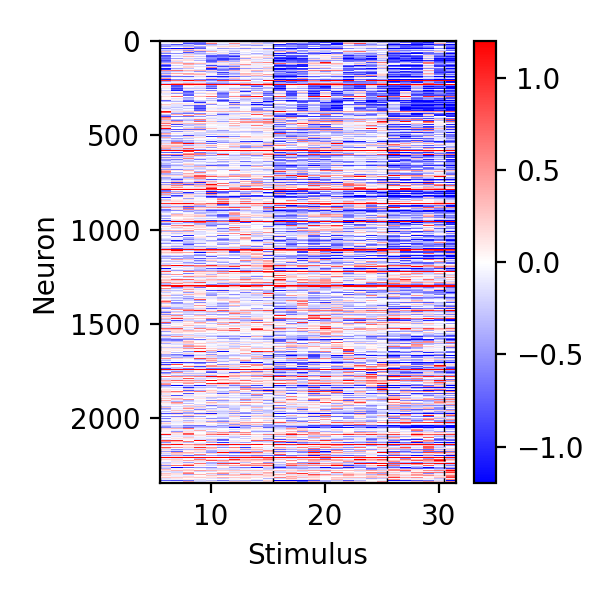

In [714]:
# compute linear model from last third and plot linear difference

def create_linear_model(curves, stim_log):
    stim_log_mult = np.concatenate((np.ones((1,32)), stim_log), axis=0) # add offset term
    linear_model_curves = np.einsum('ij,jk->ik', curves[:,:6], stim_log_mult)
    return linear_model_curves

linear_model = create_linear_model(curves_sel[:,:,-1], stim_log) # compute linear model from last third
linear_model_avg = create_linear_model(np.nanmean(curves_sel,2), stim_log) # compute linear model from average
# linear_model3 = np.zeros(linear_model.shape[:2]+(3,))
linear_model3 = np.zeros(curves_sel.shape)
for isplit in range(curves_sel.shape[2]):
    linear_model3[:,:,isplit] = create_linear_model(curves_sel[:,:,isplit], stim_log)

lin_diff = curves_sel[:,:,-1] - linear_model # compute linear difference
lin_diff_avg = np.nanmean(curves_sel,2) - linear_model_avg
lin_diff3 = curves_sel - linear_model3

lin_diff_norm = lin_diff/curves_sel[:,:,-1].max(axis=1)[:,np.newaxis] # normalize linear difference

plt.figure(figsize=(3,3))
order = sort_tuning_curves(curves_sel[is_c][:,:,:2].mean(axis=2)) # determine order based on first two-thirds of data
tuning_curve_matrix(lin_diff_norm[is_c][order], LD=True, clim=(-1.2,1.2)) # display linear difference of last thirds

plt.tight_layout()

if thirds:
    plt.savefig('figures/data_linear_difference_thirds.eps')
else:
    plt.savefig('figures/data_linear_difference.eps')

# Compute and plot linear model with variance matched to observed data

<IPython.core.display.Javascript object>


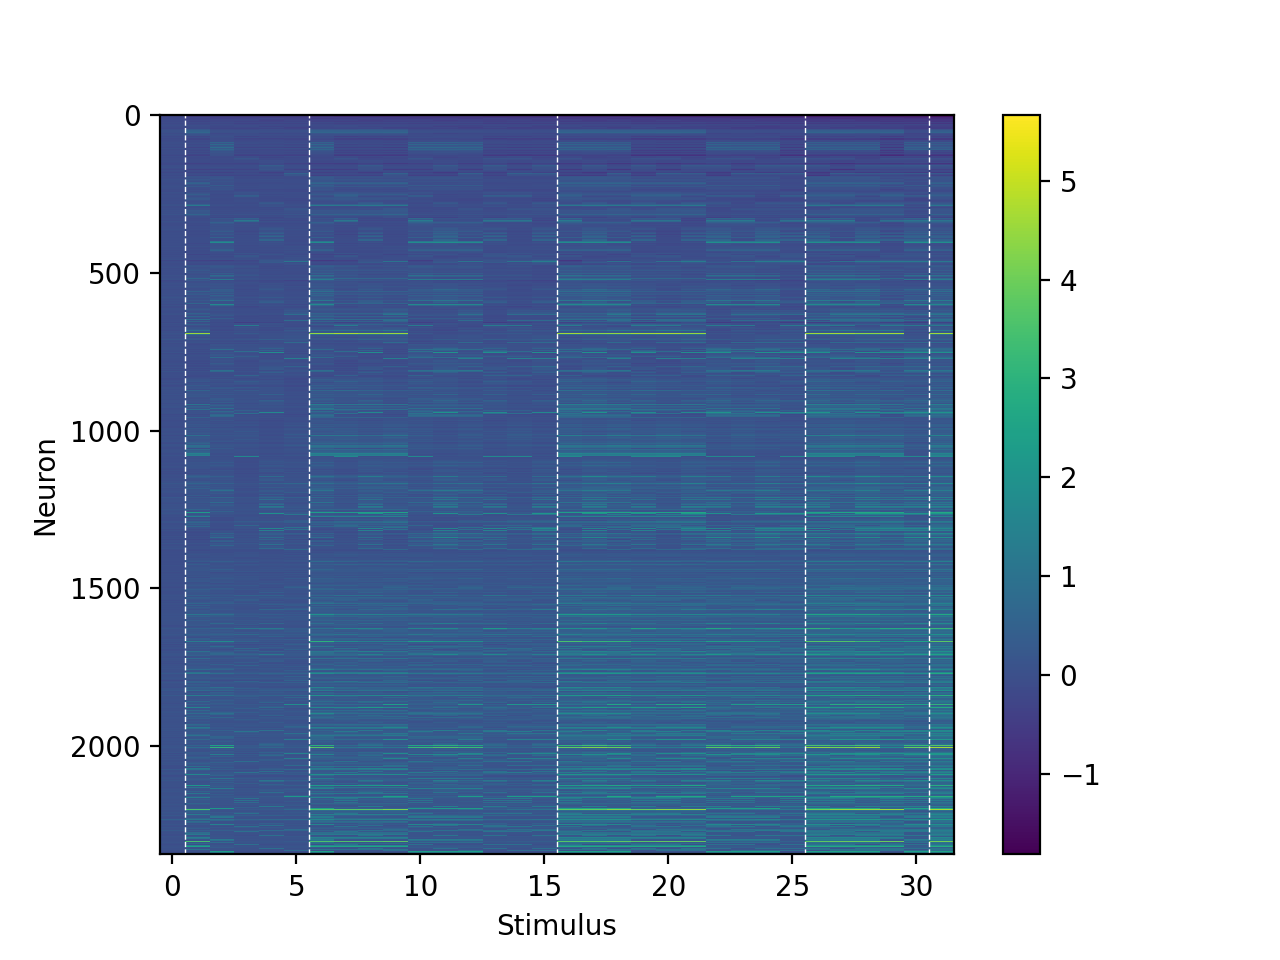

In [715]:
# compute linear model from all trials

curves_all = create_curves(raw, n_splits=1).squeeze() # compute tuning curves from all data
curves_all_sel = curves_all[index] # keep only neurons selected earlier
linear_model_all = create_linear_model(curves_all_sel, stim_log) # compute linear model

plt.figure()
order = sort_tuning_curves(linear_model_all[is_c]) # determine order from model itself
tuning_curve_matrix(linear_model_all[is_c][order], LD=False) # display curves

In [716]:
ddof = 1

<IPython.core.display.Javascript object>


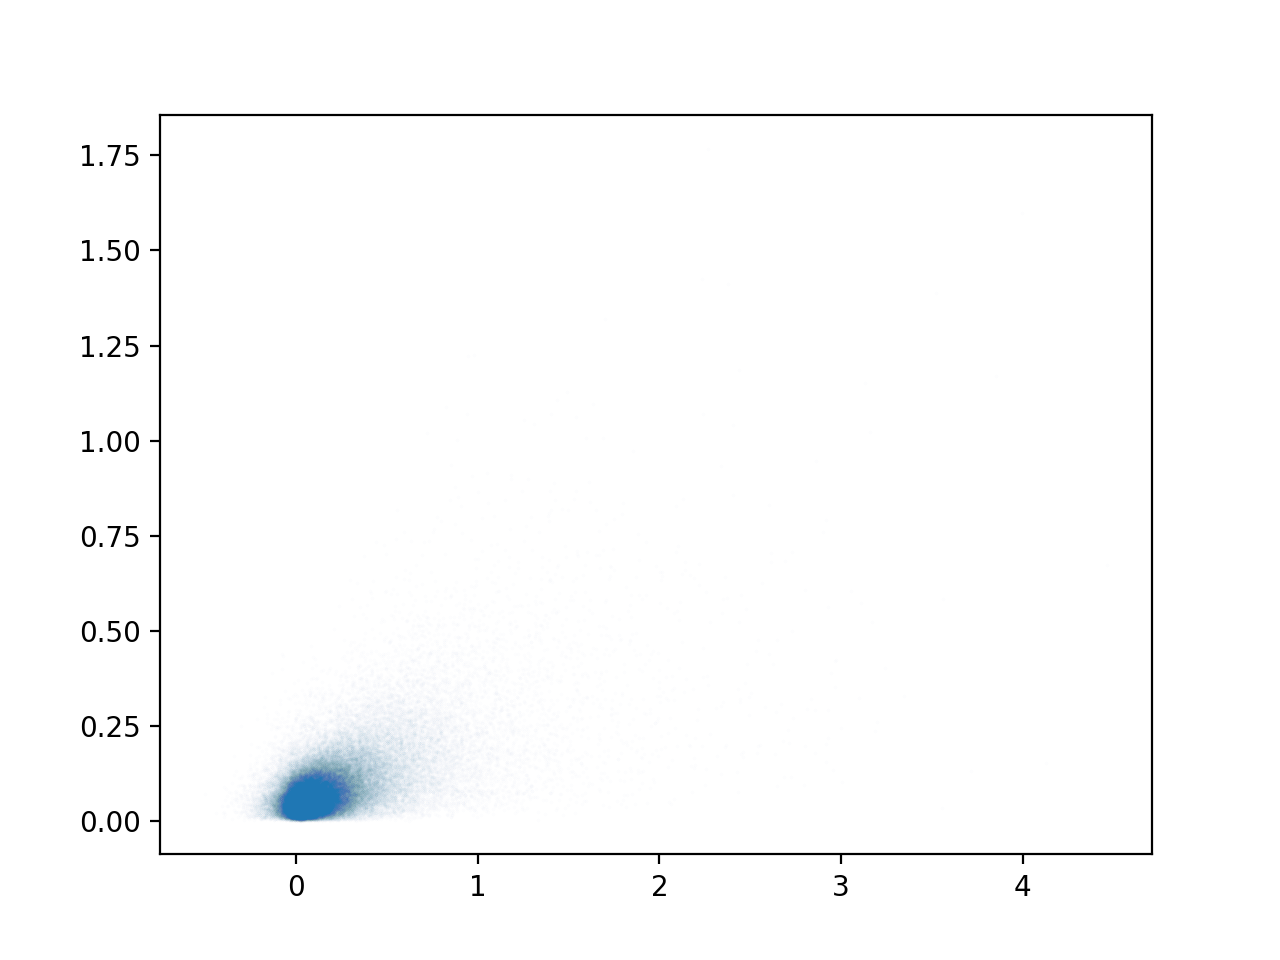

In [717]:
plt.figure()
x, y = curves_sel.mean(-1), np.std(curves_sel, axis=2, ddof=ddof)
slp = np.mean(x*y)/np.mean(x**2)
plt.scatter(x, y, s=0.1,alpha=0.01)

In [718]:
def plot_curves(noise,signal=0,use_slp=False,plot_pref=False):
    # add noise and plot model curves
    linear_model_curves = np.repeat(linear_model_all[:,:,np.newaxis], curves_sel.shape[2], axis=2) # copy twice
    linear_model_curves = linear_model_curves + signal
    if not use_slp:
        linear_model_curves = linear_model_curves + noise # add noise
    else:
        linear_model_curves = linear_model_curves + slp*linear_model_curves*noise # add noise

    plt.figure(figsize=(3,3))
    this_is_c = is_correlated(linear_model_curves, pval_cutoff=0.05)
    this_order = sort_tuning_curves(linear_model_curves[this_is_c][:,:,:-1].mean(axis=2)) # determine order based on first two-thirds of data
    mx = np.max(linear_model_curves[this_is_c][this_order,:,-1],axis=1)[:,np.newaxis]
    tuning_curve_matrix(linear_model_curves[this_is_c][this_order,:,-1]/mx, LD=False, clim=[0,1]) # plot last third
    
    best_stim = np.argmax(np.nanmean(linear_model_curves[this_is_c][:,:,:-1],2), axis=1)
    plt.plot(best_stim[this_order],np.arange(best_stim.shape[0]),c='m')
    
    plt.tight_layout()
    
    return linear_model_curves[this_is_c][this_order,:,-1]/mx

In [719]:
def plot_noise(noise,signal=0,use_slp=False):
    linear_model_curves = np.repeat(linear_model_all[:,:,np.newaxis], curves_sel.shape[2], axis=2) # copy twice
    linear_model_curves = linear_model_curves + signal
    if not use_slp:
        linear_model_curves = linear_model_curves + noise # add noise
    else:
        linear_model_curves = linear_model_curves + slp*linear_model_curves*noise # add noise
    # plot the linear difference 
    
    this_is_c = is_correlated(linear_model_curves, pval_cutoff=0.05)

    lin_diff = linear_model_curves[:,:,-1] - linear_model# = noise[:,:,2]

    plt.figure(figsize=(3,3))
    this_order = sort_tuning_curves(linear_model_curves[this_is_c][:,:,:-1].mean(axis=2)) # determine order based on first two-thirds of data
    mx = np.max(linear_model_curves[this_is_c][this_order,:,-1],axis=1)[:,np.newaxis]
    #     tuning_curve_matrix(noise[order,:,-1], LD=True, clim=(-1.2,1.2)) # display noise for last third
    tuning_curve_matrix(lin_diff[this_is_c][this_order]/mx, LD=True, clim=(-1.2,1.2)) # display noise for last third
    
    plt.tight_layout()
    
    return lin_diff[this_is_c][this_order]/mx

In [720]:
def sort_stims(noise,signal=0,use_slp=False,noise_pct=None,show_matrix=True,expt_ids=None):
    linear_model_curves = np.repeat(linear_model_all[:,:,np.newaxis], curves_sel.shape[2], axis=2) # copy twice
    linear_model_curves_signal = linear_model_curves + signal
    if not use_slp:
        linear_model_curves = linear_model_curves_signal + noise # add noise
    else:
        linear_model_curves = linear_model_curves_signal + slp*linear_model_curves*noise # add noise
    # plot the linear difference 
    
    this_is_c = is_correlated(linear_model_curves, pval_cutoff=0.05)

    lin_diff = linear_model_curves[:,:,-1] - linear_model# = noise[:,:,2]

    this_order = sort_tuning_curves(linear_model_curves[this_is_c][:,:,:-1].mean(axis=2)) # determine order based on first two-thirds of data
    this_stim_order = sort_stims_per_neuron(linear_model_curves[this_is_c][:,:,:-1].mean(axis=2)) # determine order based on first two-thirds of data
    mx = np.max(linear_model_curves[this_is_c][this_order,:,-1],axis=1)[:,np.newaxis]
    #     tuning_curve_matrix(noise[order,:,-1], LD=True, clim=(-1.2,1.2)) # display noise for last third
    
    to_return = lin_diff[this_is_c][this_order]/mx
    for iroi in range(to_return.shape[0]):
        to_return[iroi] = to_return[iroi][this_stim_order[iroi]]
        
    if not expt_ids is None:
        expt_ids_to_return = expt_ids[this_is_c][this_order]
        
    if not noise_pct is None:
        if not use_slp:
            linear_model_curves_pct = [linear_model_curves_signal + n_pct for n_pct in noise_pct] # add noise
        else:
            linear_model_curves_pct = [linear_model_curves + slp*linear_model_curves*n_pct for n_pct in noise_pct] # add noise
        lin_diff_pct = [lmc_pct[:,:,-1] - linear_model for lmc_pct in linear_model_curves_pct]# = noise[:,:,2]
        to_return_pct = [ld_pct[this_is_c][this_order]/mx for ld_pct in lin_diff_pct]
        for ipct in range(len(to_return_pct)):
            for iroi in range(to_return.shape[0]):
                to_return_pct[ipct][iroi] = to_return_pct[ipct][iroi][this_stim_order[iroi]]
    if show_matrix:
        plt.figure()
        tuning_curve_matrix(to_return, LD=True, clim=(-1.2,1.2)) # display noise for last third
    
    if not expt_ids is None:
        if not noise_pct is None:
            return to_return, to_return_pct, expt_ids_to_return
        else:
            return to_return, expt_ids_to_return
    else:
        if not noise_pct is None:
            return to_return, to_return_pct
        else:
            return to_return


In [721]:
def plot_lin_subtracted_pdfs(lin_subtracted_sorted):
    bins = np.linspace(-1.5,1.5,100)
    rgs = [slice(0,1),slice(1,None)]
    cs = ['r','b']
    for irg in range(len(rgs)):
        ut.bar_pdf(np.nanmean(lin_subtracted_sorted[:,rgs[irg]],axis=1),bins=bins,alpha=0.5,facecolor=cs[irg])
    ut.erase_top_right()
    plt.xlabel('Normalized linear difference')
    plt.ylabel('frac. of neurons')

In [722]:
def plot_lin_subtracted_pdfs_sig_comparison(lin_subtracted_sorted,lin_subtracted_sorted_bounds=None,sig_above=False,sig_c='k',compare_to_zero=True):
    bins = np.linspace(-1.5,1.5,100)
    rgs = [slice(0,1),slice(1,None)]
    
    irg = 0
    bds_rg0 = [np.nanmean(lin_subtracted_sorted_bounds[ibd][:,rgs[irg]],axis=1) for ibd in range(2)]
    irg = 1
    val_rg1 = np.nanmean(lin_subtracted_sorted[:,rgs[irg]],axis=1)
    
    if compare_to_zero:
        sig_greater = (bds_rg0[0] > 0) 
        sig_less = (bds_rg0[1] < 0)
    else:
        sig_greater = (bds_rg0[0] > val_rg1)
        sig_less = (bds_rg0[1] < val_rg1)
    
    sig = sig_greater | sig_less
    
#     cs = ['r','b']
    cs = [np.array((1,0.5,0.5)),np.array((0,0,1))]
#     sig_c = 'c'
    for irg in range(1):#len(rgs)):
        ut.bar_pdf_sig(np.nanmean(lin_subtracted_sorted[:,rgs[irg]],axis=1),
                       bins=bins,
                       alpha=0.5,
                       facecolor=cs[irg],
                       sig_facecolor=sig_c,
                       sig=sig,
#                        edgecolor='k',
                       sig_above=sig_above)
    for irg in range(1,2):#len(rgs)):
        ut.bar_pdf(np.nanmean(lin_subtracted_sorted[:,rgs[irg]],axis=1),
                       bins=bins,
                       alpha=0.5,
                       facecolor=cs[irg])
    ut.erase_top_right()
    plt.xlabel('Normalized linear difference')
    plt.ylabel('frac. of neurons')

In [723]:
def scatter_lin_subtracted_sig_comparison(lin_subtracted_sorted,lin_subtracted_sorted_bounds=None,sig_above=False,
                                          sig_c='k',compare_to_zero=True,s=8,alpha=1,show_expt_means=False,
                                          expt_ids=None,is_layer23=None):
    rgs = [slice(0,1),slice(1,None)]
    
    irg = 0
    bds_rg0 = [np.nanmean(lin_subtracted_sorted_bounds[ibd][:,rgs[irg]],axis=1) for ibd in range(2)]
    irg = 1
    val_rg1 = np.nanmean(lin_subtracted_sorted[:,rgs[irg]],axis=1)
    
    if compare_to_zero:
        sig_greater = (bds_rg0[0] > 0) 
        sig_less = (bds_rg0[1] < 0)
    else:
        sig_greater = (bds_rg0[0] > val_rg1)
        sig_less = (bds_rg0[1] < val_rg1)
    
    sig = sig_greater | sig_less
    
    ydata,xdata = [np.nanmean(lin_subtracted_sorted[:,rgs[irg]],axis=1) for irg in range(2)]
    cs = ['w','r','b']
    for isig,to_plot in enumerate([~sig,sig_greater,sig_less]):
        plt.scatter(xdata[to_plot],ydata[to_plot],c=cs[isig],s=s,edgecolor='k',linewidth=0.3,alpha=alpha)
    cs = [np.array(((0,0,0))),np.array(((0.5,0.5,0.5)))]
    if show_expt_means:
        for ilayer,to_plot in enumerate([~is_layer23,is_layer23]):
            these = to_plot[expt_ids]
            ydata_mean,xdata_mean = [scf.average_expt_means(expt_ids[these],zdata[these],int(np.nanmax(expt_ids)+1)) for zdata in [ydata,xdata]]
            plt.scatter(xdata_mean,ydata_mean,s=3*s,c=cs[ilayer],edgecolor='w')
            print((xdata_mean,ydata_mean))
#         print((np.nanmean(xdata),np.nanmean(ydata)))
        
    lim = 1.2    
    
    plt.plot((-lim,lim),(-lim,lim),c='k')
    plt.axhline(0,c='k',linestyle='dashed')
    plt.axvline(0,c='k',linestyle='dashed')
    plt.xlim((-lim,lim))
    plt.ylim((-lim,lim))
    
    ut.erase_top_right()
    plt.xlabel('Norm. linear difference, \n non-top-ranked')
    plt.ylabel('Norm. linear difference, \n top-ranked')
    return xdata,ydata

In [724]:
sorted_noise_pct[0].shape

(2623, 32)

In [725]:
expt_ids_sorted

array([2, 7, 1, ..., 5, 1, 4])

In [726]:
is_layer23.shape

(31,)

In [727]:
save_fig = False
def run_save(name_base='shared_plus_split_noise_linear_difference',save_fig=save_fig,thirds=thirds,jpg=False):
    if save_fig:
        if thirds:
            if jpg:
                plt.savefig('figures/%s_thirds.jpg'%name_base,dpi=300)
            else:
                plt.savefig('figures/%s_thirds.eps'%name_base)
        else:
            if jpg:
                plt.savefig('figures/%s_halves.jpg'%name_base,dpi=300)
            else:
                plt.savefig('figures/%s_halves.eps'%name_base)

In [728]:
from importlib import reload
reload(ut)

<module 'pyute' from '/Users/dan/Documents/code/adesnal/pyute.py'>

<IPython.core.display.Javascript object>


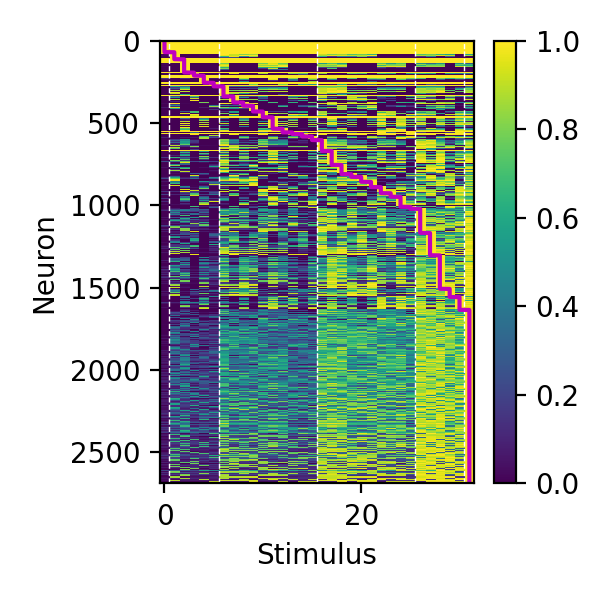

<IPython.core.display.Javascript object>


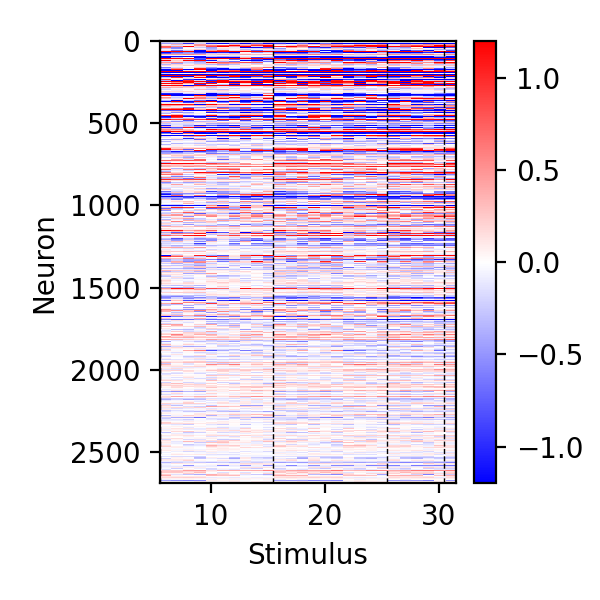

<IPython.core.display.Javascript object>


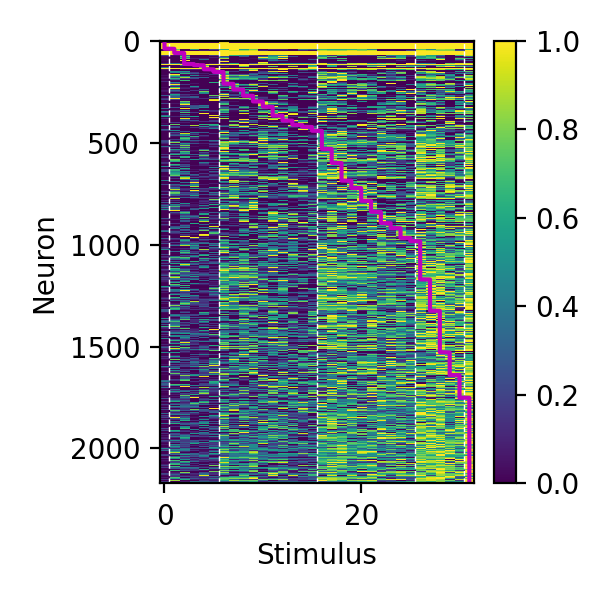

<IPython.core.display.Javascript object>


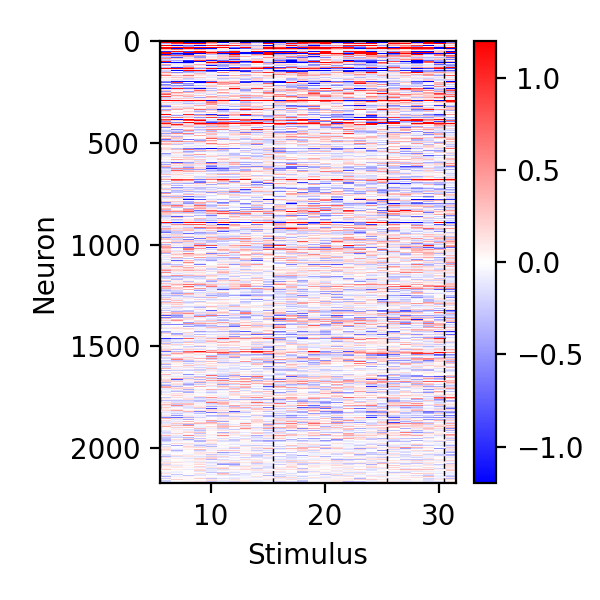

0/2692
100/2692
200/2692
300/2692
400/2692
500/2692
600/2692
700/2692
800/2692
900/2692
1000/2692
1100/2692
1200/2692
1300/2692
1400/2692
1500/2692
1600/2692
1700/2692
1800/2692
1900/2692
2000/2692
2100/2692
2200/2692
2300/2692
2400/2692
2500/2692
2600/2692


<IPython.core.display.Javascript object>


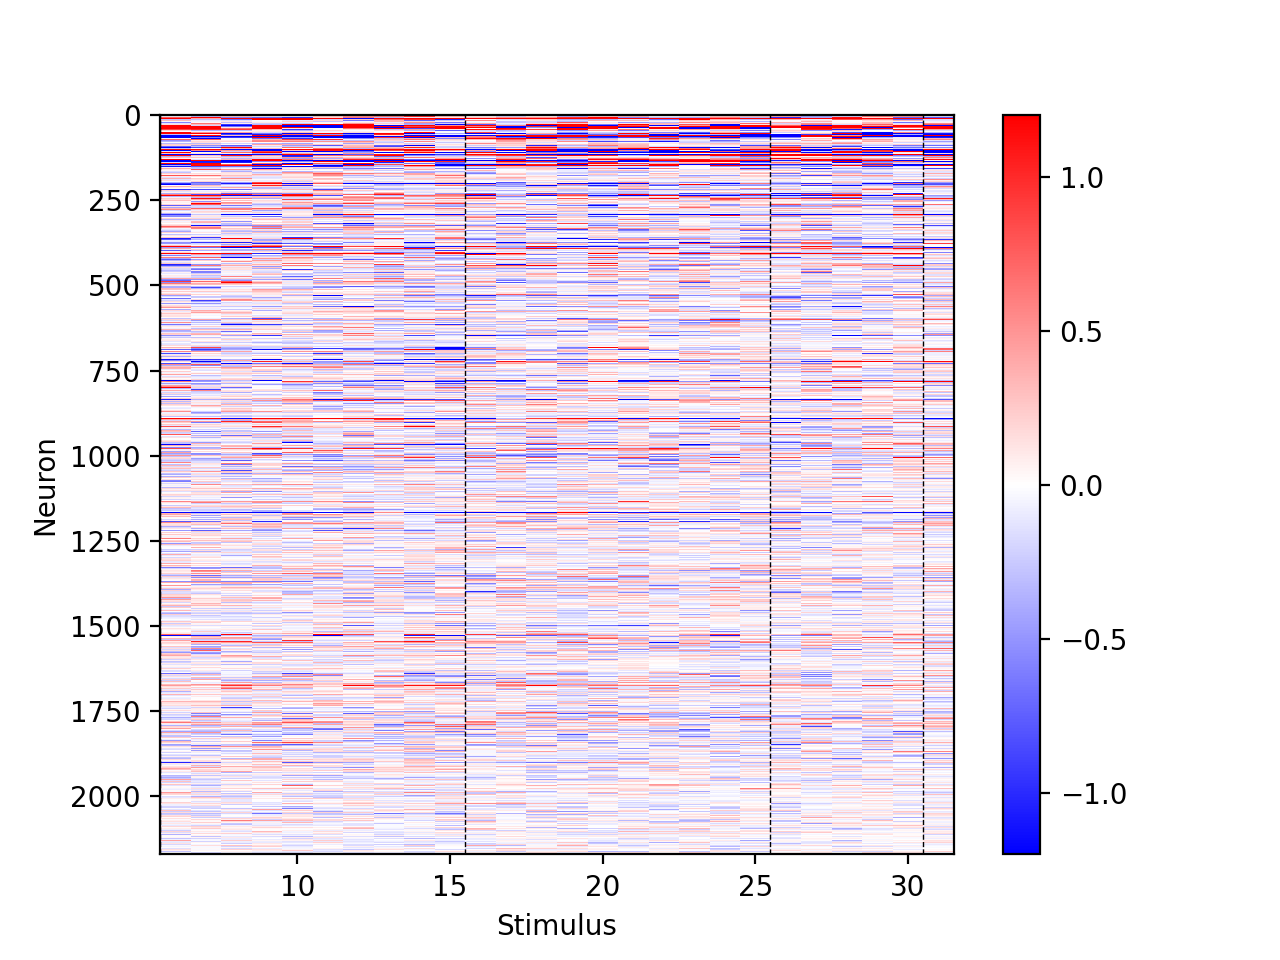

<IPython.core.display.Javascript object>


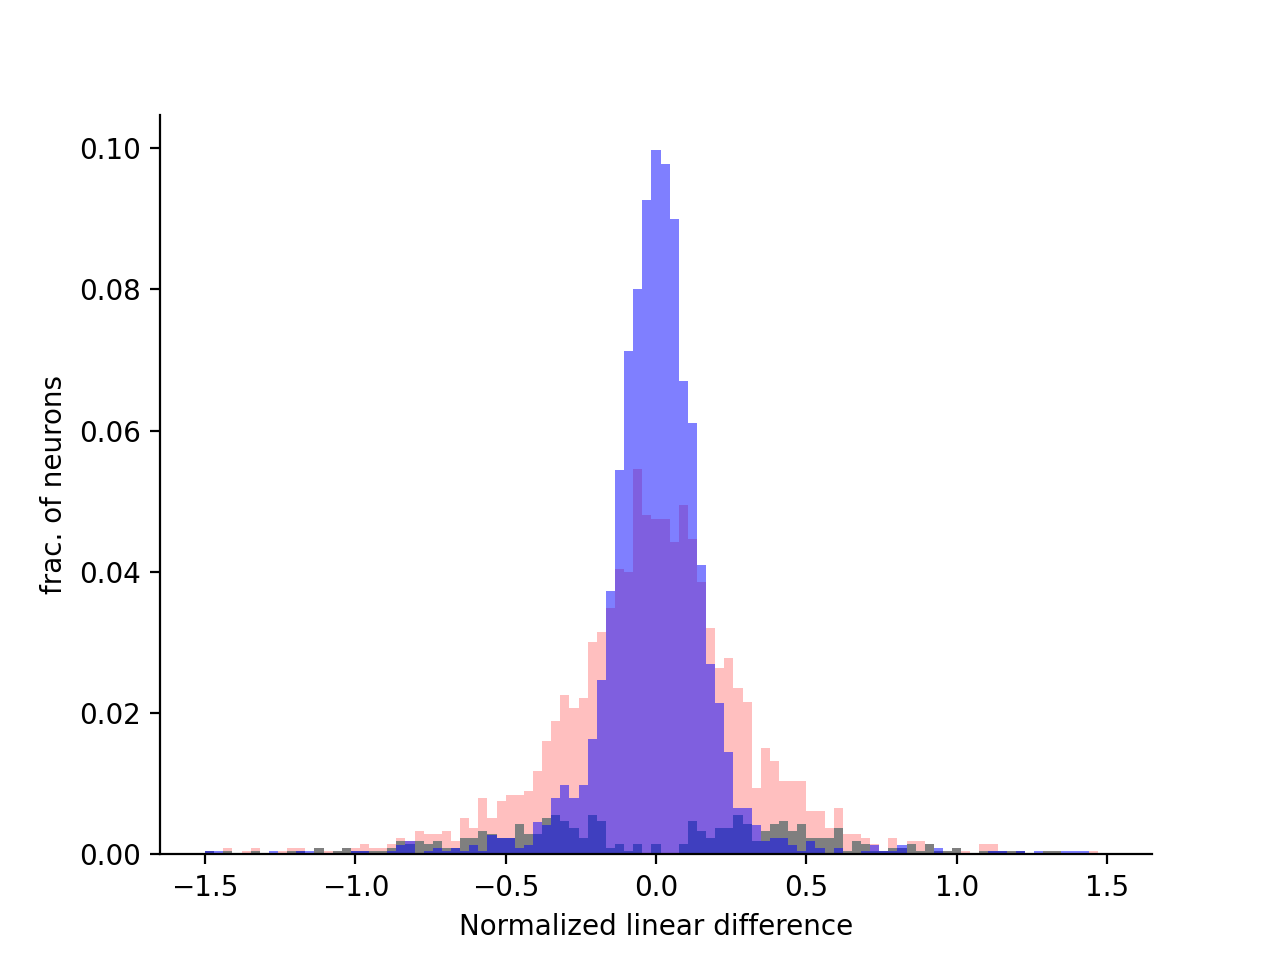

<IPython.core.display.Javascript object>


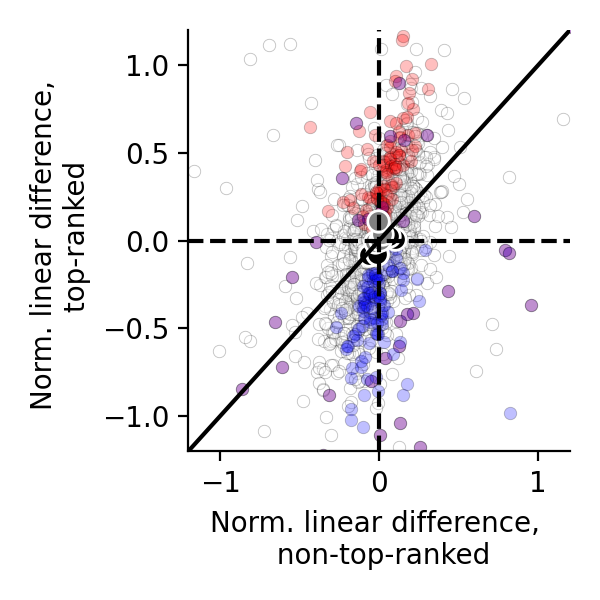

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(array([        nan,         nan,         nan,         nan,         nan,
        0.09800021,  0.06000514, -0.02703873, -0.01662453, -0.06319485,
       -0.01416902]), array([        nan,         nan,         nan,         nan,         nan,
        0.0067374 ,  0.02654222, -0.02236839, -0.07782435, -0.08084779,
       -0.07554923]))
(array([        nan, -0.02346181,  0.00351339,  0.0176398 , -0.00471861,
               nan,         nan,         nan,         nan,         nan,
               nan]), array([        nan, -0.00859592,  0.00433189,  0.03723737,  0.11055063,
               nan,         nan,         nan,         nan,         nan,
               nan]))


In [729]:
use_slp = False
save_fig = True

# determine noise to add

# # std across tuning curve calculated on all data
# rng = random.default_rng(12345)
# std_observed = np.std(curves_all_sel, axis=1, ddof=ddof) # neurons x 1
# noise = np.empty(curves_sel.shape) # neurons x stim x 3
# for i in range(noise.shape[0]): # over neurons
#     noise[i,:,:] = rng.normal(0, std_observed[i], (32,3))

# std across tuning curves calculated on thirds of data
rng = random.default_rng(12345)
# std_observed = np.std(curves_sel, axis=1, ddof=ddof).squeeze() # neurons x 3
std_observed = np.std(lin_diff3, axis=1, ddof=ddof).squeeze() # neurons x 3
noise = np.empty(curves_sel.shape) # neurons x stim x 3
for i in range(noise.shape[0]): # over neurons
    for j in range(noise.shape[2]): # over splits
        noise[i,:,j] = rng.normal(0, std_observed[i,j], 32)

lmc = plot_curves(0*noise, use_slp=use_slp)
plot_noise(0*noise, use_slp=use_slp)
# plt.savefig('figures/all_noise_linear_difference_thirds.eps')
# plt.savefig('figures/all_noise_linear_difference_halves.eps')
        
# std across splits
rng = random.default_rng(12345)
# std_observed = np.std(curves_sel, axis=2, ddof=ddof).squeeze() # neurons x stim x 1
std_observed_split = np.std(lin_diff3, axis=2, ddof=ddof).squeeze() # neurons x stim x 1
noise = np.empty(curves_sel.shape) # neurons x stim x 3
noise_trialwise = np.empty(curves_sel.shape+(n_trials_per_split,))
for i in range(noise.shape[0]): # over neurons
    for j in range(noise.shape[1]): # over stimuli
#         noise[i,j,:] = rng.normal(0, np.mean(std_observed_split[i,:]), curves_sel.shape[2])
# #         noise[i,j,:] = rng.normal(0, std_observed[i,j], 3)
#         noise[i,j,:] = rng.normal(0, std_observed_split[i,j], curves_sel.shape[2])
        noise_trialwise[i,j,:,:] = rng.normal(0, np.sqrt(n_trials_per_split)*np.mean(std_observed_split[i,:]), 
                                            (curves_sel.shape[2],n_trials_per_split))
        noise[i,j,:] = np.mean(noise_trialwise[i,j,:,:],axis=1)
        
plotted_curves = plot_curves(noise, use_slp=use_slp)
plotted_noise = plot_noise(noise, use_slp=use_slp)
run_save(name_base='split_noise_linear_difference',save_fig=save_fig,thirds=thirds)

pct = (0.05,99.95,50)
noise_pct = [np.zeros_like(noise) for _ in range(3)]
for i in range(noise.shape[0]):
    if i % 100 == 0:
        print('%d/%d'%(i,lb.shape[0]))
    noise_pct[0][i:i+1],noise_pct[1][i:i+1],noise_pct[2][i:i+1] = ut.bootstrap(noise_trialwise[i:i+1],axis=3,fn=np.mean,pct=pct,nreps=1000)

sorted_noise,sorted_noise_pct,expt_ids_sorted = sort_stims(noise,use_slp=use_slp, noise_pct=noise_pct, signal=0, expt_ids=expt_ids[index])
plt.figure()
plot_lin_subtracted_pdfs_sig_comparison(sorted_noise,lin_subtracted_sorted_bounds=sorted_noise_pct,
                                        sig_above=False,sig_c='k')
run_save(name_base='split_noise_linear_difference_hists',save_fig=save_fig,thirds=thirds,jpg=True)

# plt.figure()
# scatter_lin_subtracted_sig_comparison(sorted_noise,lin_subtracted_sorted_bounds=sorted_noise_pct,
#                                       compare_to_zero=False,show_expt_means=True,expt_ids=expt_ids[index])
# plt.tight_layout()
# run_save(name_base='split_noise_linear_difference_scatter',save_fig=save_fig,thirds=thirds)

# plt.figure()
# scatter_lin_subtracted_sig_comparison(sorted_noise,lin_subtracted_sorted_bounds=sorted_noise_pct,compare_to_zero=True)
# plt.tight_layout()
# run_save(name_base='split_noise_linear_difference_scatter_compare_to_zero',save_fig=save_fig,thirds=thirds)


plt.figure(figsize=(3,3))
xdata,ydata = scatter_lin_subtracted_sig_comparison(sorted_noise,lin_subtracted_sorted_bounds=sorted_noise_pct,
                                      compare_to_zero=False,show_expt_means=True,expt_ids=expt_ids_sorted,
                                                    s=20,is_layer23=is_layer23,alpha=0.25)
plt.tight_layout()
run_save(name_base='split_noise_linear_difference_scatter',save_fig=save_fig,thirds=thirds,jpg=True)

<IPython.core.display.Javascript object>


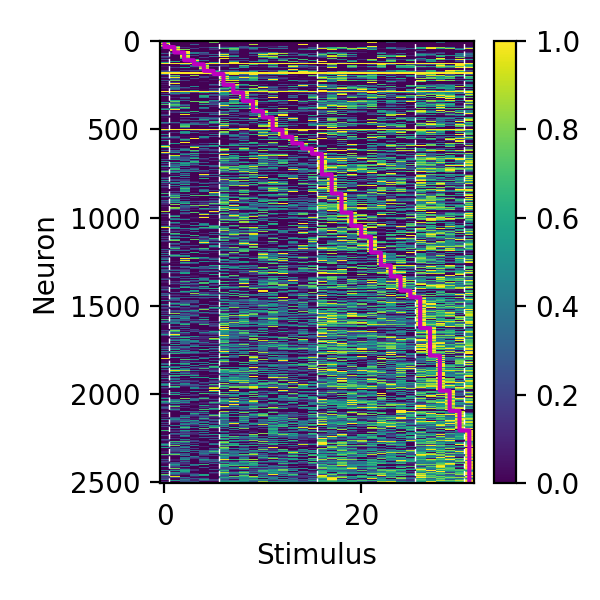

<IPython.core.display.Javascript object>


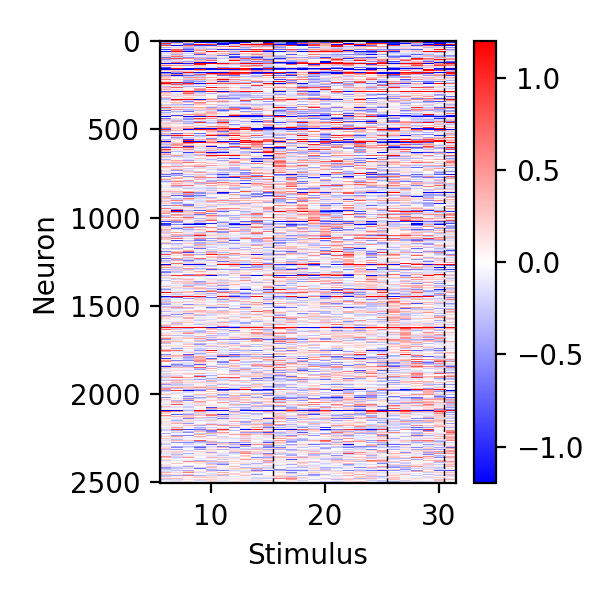

0/2692
100/2692
200/2692
300/2692
400/2692
500/2692
600/2692
700/2692
800/2692
900/2692
1000/2692
1100/2692
1200/2692
1300/2692
1400/2692
1500/2692
1600/2692
1700/2692
1800/2692
1900/2692
2000/2692
2100/2692
2200/2692
2300/2692
2400/2692
2500/2692
2600/2692


<IPython.core.display.Javascript object>


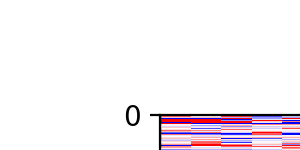

<IPython.core.display.Javascript object>


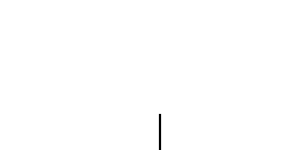

<IPython.core.display.Javascript object>


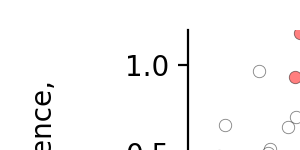

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(array([        nan,         nan,         nan,         nan,         nan,
       -0.01710777,  0.01804947, -0.01539862,  0.00210223,  0.02268033,
        0.07551482]), array([        nan,         nan,         nan,         nan,         nan,
        0.28613784,  0.44102215,  0.39093029,  0.32670928,  0.31399285,
       -0.16696601]))
(array([        nan, -0.00723758, -0.04770713, -0.04837117, -0.06399039,
               nan,         nan,         nan,         nan,         nan,
               nan]), array([       nan, 0.36669589, 0.05052728, 0.2844624 , 0.31477877,
              nan,        nan,        nan,        nan,        nan,
              nan]))


In [730]:
# std across linear difference calculated on all data, plus across splits
rng = random.default_rng(12345)
# std_observed_mean = np.std(curves_all_sel, axis=1, ddof=ddof) # neurons x 1
std_observed_mean = np.std(lin_diff_avg, axis=1, ddof=ddof)
# std_observed_split = np.std(curves_sel, axis=2).squeeze() # neurons x stim x 1
std_observed_split = np.std(lin_diff3, axis=2, ddof=ddof).squeeze() # neurons x stim x 1
signal = np.empty(curves_sel.shape) # neurons x stim x 3
noise = np.empty(curves_sel.shape) # neurons x stim x 3
for i in range(noise.shape[0]): # over neurons
    signal[i,:,:] = rng.normal(0, std_observed_mean[i], 32)[:,np.newaxis]
    for j in range(noise.shape[1]): # over stimuli
#         noise[i,j,:] = noise[i,j,:] + rng.normal(0, std_observed_split[i,j], curves_sel.shape[2])
#         noise[i,j,:] = signal[i,j,:] + rng.normal(0, np.mean(std_observed_split[i,:]), curves_sel.shape[2])
#         noise[i,j,:] = rng.normal(0, np.mean(std_observed_split[i,:]), curves_sel.shape[2])
        noise_trialwise[i,j,:,:] = rng.normal(0, np.sqrt(n_trials_per_split)*np.mean(std_observed_split[i,:]), 
                                            (curves_sel.shape[2],n_trials_per_split))
        noise[i,j,:] = np.mean(noise_trialwise[i,j,:,:],axis=1)


plotted_curves = plot_curves(noise, signal=signal, use_slp=use_slp)
plotted_noise = plot_noise(noise, signal=signal, use_slp=use_slp)
run_save(name_base='shared_plus_split_noise_linear_difference',save_fig=save_fig,thirds=thirds)

pct = (0.05,99.95,50)
noise_pct = [np.zeros_like(noise) for _ in range(3)]
for i in range(noise.shape[0]):
    if i % 100 == 0:
        print('%d/%d'%(i,lb.shape[0]))
    noise_pct[0][i:i+1],noise_pct[1][i:i+1],noise_pct[2][i:i+1] = ut.bootstrap(noise_trialwise[i:i+1],axis=3,fn=np.mean,pct=pct,nreps=10000)

sorted_noise,sorted_noise_pct,expt_ids_sorted = sort_stims(noise,use_slp=use_slp, noise_pct=noise_pct, signal=signal, expt_ids=expt_ids[index])
plt.figure()
# plot_lin_subtracted_pdfs(sorted_noise)
plot_lin_subtracted_pdfs_sig_comparison(sorted_noise,lin_subtracted_sorted_bounds=sorted_noise_pct,sig_above=False,sig_c='k')
run_save(name_base='shared_plus_split_noise_linear_difference_hists',save_fig=save_fig,thirds=thirds,jpg=True)

# plt.figure()#figsize=(2.5,2.5))
# scatter_lin_subtracted_sig_comparison(sorted_noise,lin_subtracted_sorted_bounds=sorted_noise_pct,compare_to_zero=False)
# plt.tight_layout()
# run_save(name_base='shared_plus_split_noise_linear_difference_scatter',save_fig=save_fig,thirds=thirds)

# plt.figure()#figsize=(2.5,2.5))
# scatter_lin_subtracted_sig_comparison(sorted_noise,lin_subtracted_sorted_bounds=sorted_noise_pct,compare_to_zero=True)
# plt.tight_layout()
# run_save(name_base='shared_plus_split_noise_linear_difference_scatter_compare_to_zero',save_fig=save_fig,thirds=thirds)

plt.figure(figsize=(3,3))#figsize=(2.5,2.5))
xdata,ydata = scatter_lin_subtracted_sig_comparison(sorted_noise,lin_subtracted_sorted_bounds=sorted_noise_pct,
                                      compare_to_zero=False,show_expt_means=True,expt_ids=expt_ids_sorted,
                                                    s=20,is_layer23=is_layer23,alpha=0.5)
plt.tight_layout()
run_save(name_base='shared_plus_split_noise_linear_difference_scatter',save_fig=save_fig,thirds=thirds,jpg=True)

In [731]:
# halves stats:
# just noise
# (132, 151, 2416)
# (165, 164, 2416)
# signal + noise
# (1183, 42, 2633)
# (1170, 49, 2633)

<IPython.core.display.Javascript object>


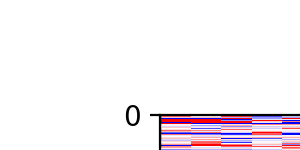

In [732]:
sorted_noise = sort_stims(noise, signal=signal, use_slp=use_slp)

In [162]:
plot_lin_subtracted_pdfs(sorted_noise)

In [163]:
best_stim = np.argmax(lmc[:,:,0], axis=1)
this_order = sort_tuning_curves(lmc[:,:,0])
plt.figure()
tuning_curve_matrix(lmc[:,:,0][this_order])
plt.plot(best_stim[this_order],np.arange(lmc.shape[0]),c='m')

# plt.figure()
# plt.plot(best_stim[this_order])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed